In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kabure/german-credit-data-with-risk")

print("Path to dataset files:", path)

100%|██████████| 11.2k/11.2k [00:00<00:00, 18.9MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kabure/german-credit-data-with-risk/versions/1


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

In [15]:
import zipfile
import pandas as pd
import os

# Construct the correct path to the zip file
zip_file_path = os.path.join(path, "german_credit_data.zip")

# Extract the CSV file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extract("german_credit_data.csv")

# Load the data into a pandas DataFrame
df = pd.read_csv("german_credit_data.csv")
print(df.columns)

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


In [16]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
print(df.info())
print(df["Risk"].value_counts())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB
None
Risk
good    700
bad     300
Name: count, dtype: int64


In [23]:
df = df.drop(columns=["Unnamed: 0"]) # drop index column if present
print("Dataset shape:", df.shape)

Dataset shape: (1000, 10)


In [24]:
from IPython.display import Markdown, display


display(Markdown("""
# Explainable Credit Risk Model
This project builds an interpretable credit risk model using Logistic Regression, SHAP explainability, and model comparisons.
"""))



# Explainable Credit Risk Model
This project builds an interpretable credit risk model using Logistic Regression, SHAP explainability, and model comparisons.


In [ ]:
from IPython.display import Markdown, display


display(Markdown("""
# Explainable Credit Risk Model
This project builds an interpretable credit risk model using Logistic Regression, SHAP explainability, and model comparisons.
"""))

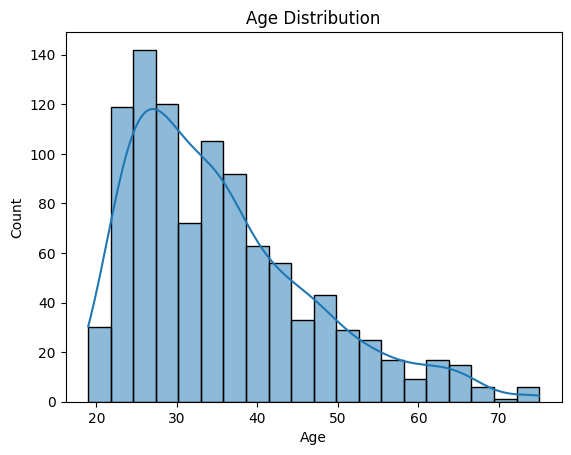

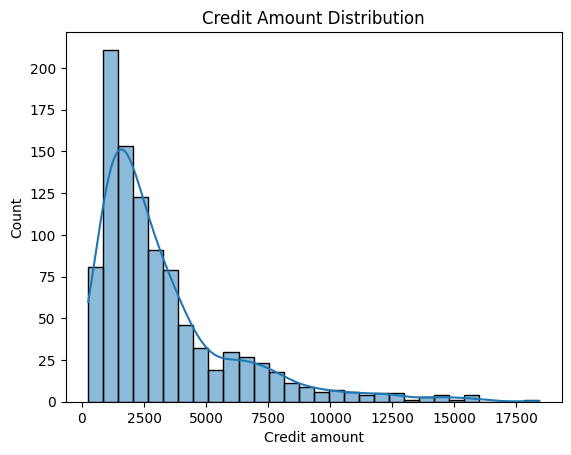

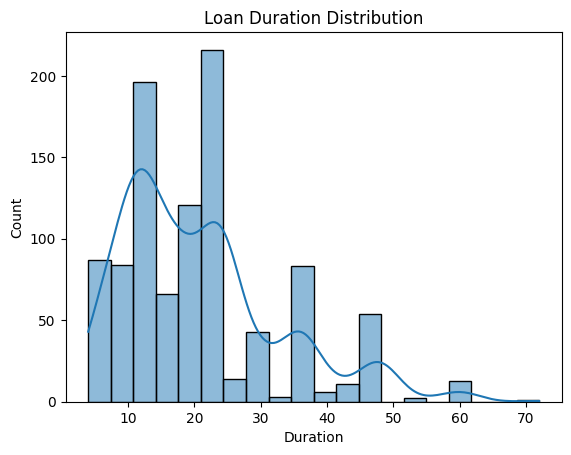

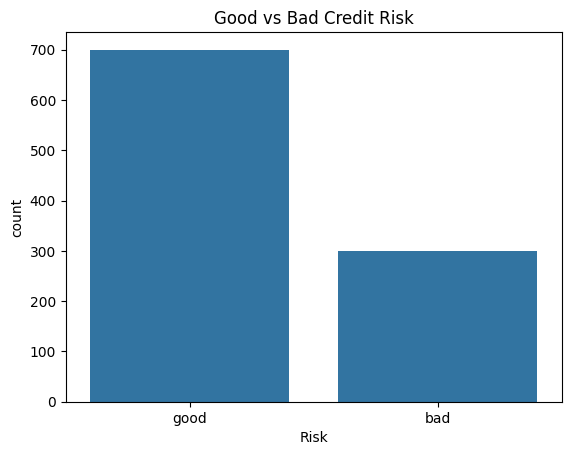

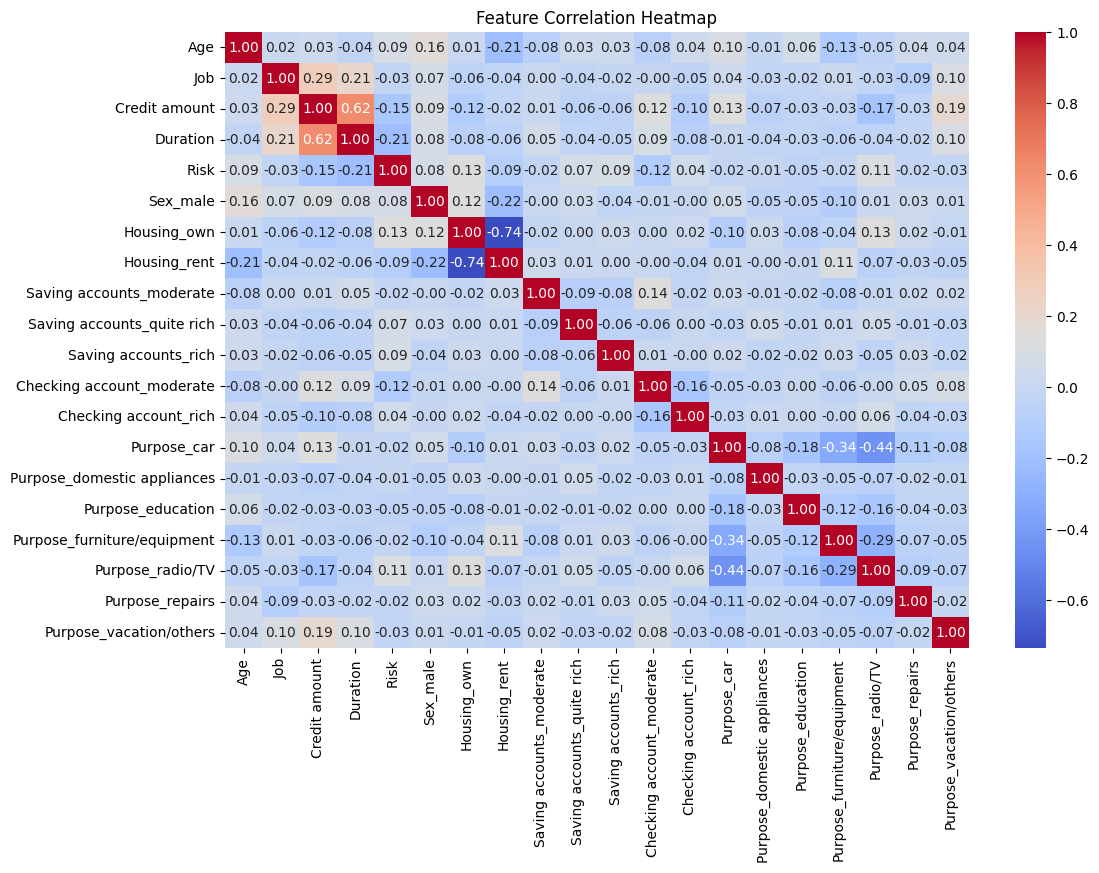

In [29]:
# 2. Exploratory Data Analysis (EDA)
sns.histplot(df['Age'], kde=True, bins=20)
plt.title("Age Distribution")
plt.show()


sns.histplot(df['Credit amount'], kde=True, bins=30)
plt.title("Credit Amount Distribution")
plt.show()


sns.histplot(df['Duration'], kde=True, bins=20)
plt.title("Loan Duration Distribution")
plt.show()


sns.countplot(x='Risk', data=df)
plt.title("Good vs Bad Credit Risk")
plt.show()


# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# 3. Feature engineering: Monthly Installment
df["Monthly_Installment"] = df["Credit amount"] / df["Duration"]

In [30]:
#4.Preprocessing
categorical_cols = ["Sex", "Job", "Housing", "Saving accounts", "Checking account", "Purpose"]
for col in categorical_cols:
  df[col] = LabelEncoder().fit_transform(df[col].astype(str))

In [31]:
# Encode target (Risk: good=0, bad=1)
y = LabelEncoder().fit_transform(df["Risk"])
X = df.drop("Risk", axis=1)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [32]:
# 5. Baseline Model (majority class)
baseline_pred = np.full_like(y_test, fill_value=y_train.mean().round())
print("Baseline Accuracy:", accuracy_score(y_test, baseline_pred))

Baseline Accuracy: 0.7


Logistic Regression Accuracy: 0.7366666666666667
F1 Score: 0.8293736501079914


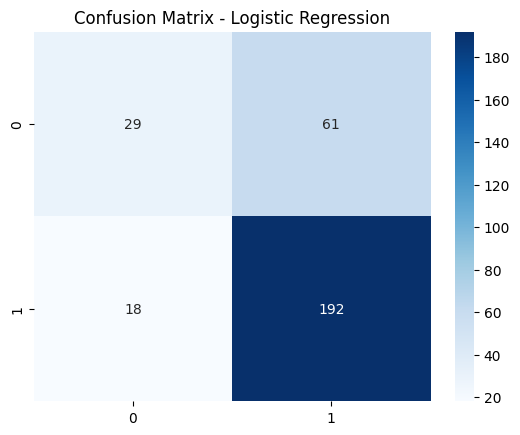

In [34]:
# 6. Logistic Regression (default)
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)


print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

Accuracy: 0.74
Precision: 0.7578125
Recall: 0.9238095238095239
F1 Score: 0.8326180257510729


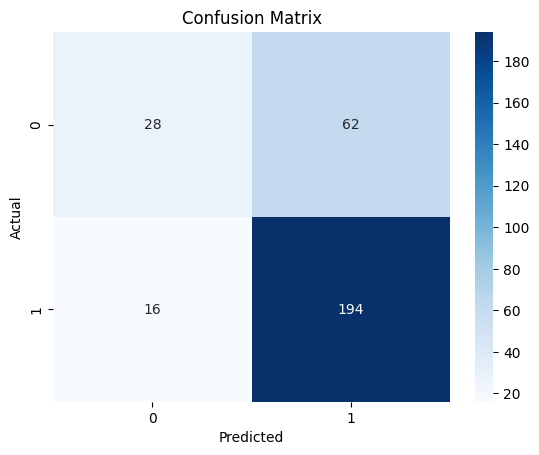

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.31      0.42        90
           1       0.76      0.92      0.83       210

    accuracy                           0.74       300
   macro avg       0.70      0.62      0.63       300
weighted avg       0.72      0.74      0.71       300



          Logistic Regression  Balanced Logistic Regression  Random Forest
Accuracy             0.736667                      0.723333       0.740000
F1 Score             0.829374                      0.785530       0.827434


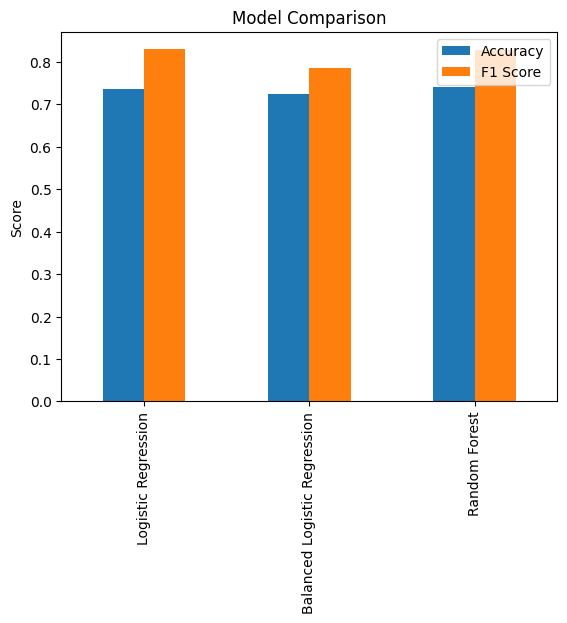

In [36]:
# 7. Model Variants & Comparison
# Logistic Regression with class_weight balanced
log_reg_balanced = LogisticRegression(max_iter=1000, class_weight='balanced')
log_reg_balanced.fit(X_train, y_train)
y_pred_bal = log_reg_balanced.predict(X_test)


# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)


# Compare metrics
models = {
"Logistic Regression": [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred)],
"Balanced Logistic Regression": [accuracy_score(y_test, y_pred_bal), f1_score(y_test, y_pred_bal)],
"Random Forest": [accuracy_score(y_test, rf_pred), f1_score(y_test, rf_pred)]
}


comparison_df = pd.DataFrame(models, index=["Accuracy", "F1 Score"])
print(comparison_df)


comparison_df.T.plot(kind='bar')
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()

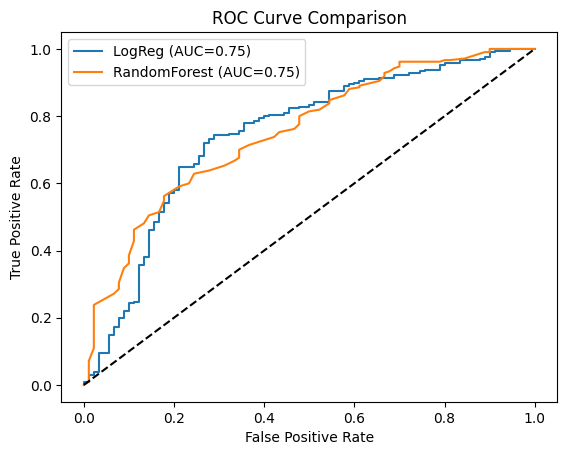

In [37]:
# 8. ROC Curves
y_prob_lr = log_reg.predict_proba(X_test)[:,1]
y_prob_rf = rf.predict_proba(X_test)[:,1]


fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)


fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc_lr:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={roc_auc_rf:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

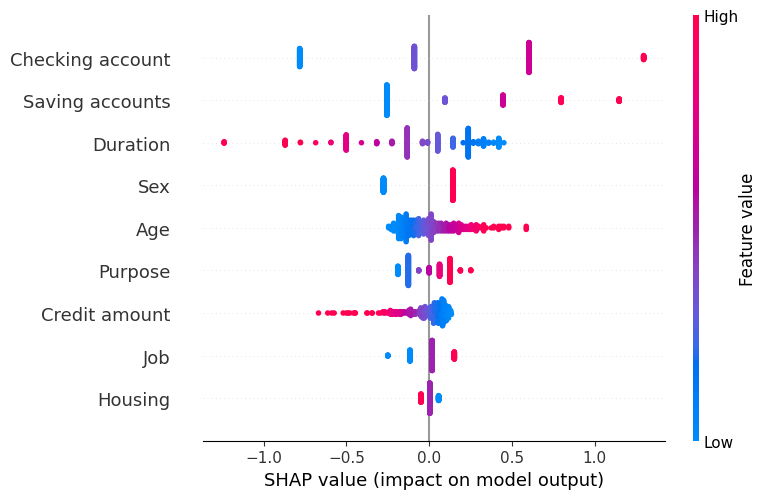

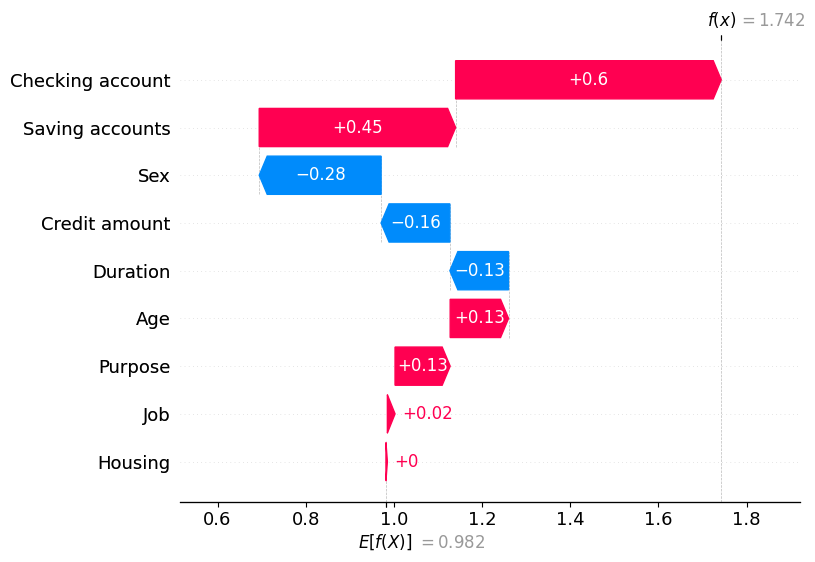

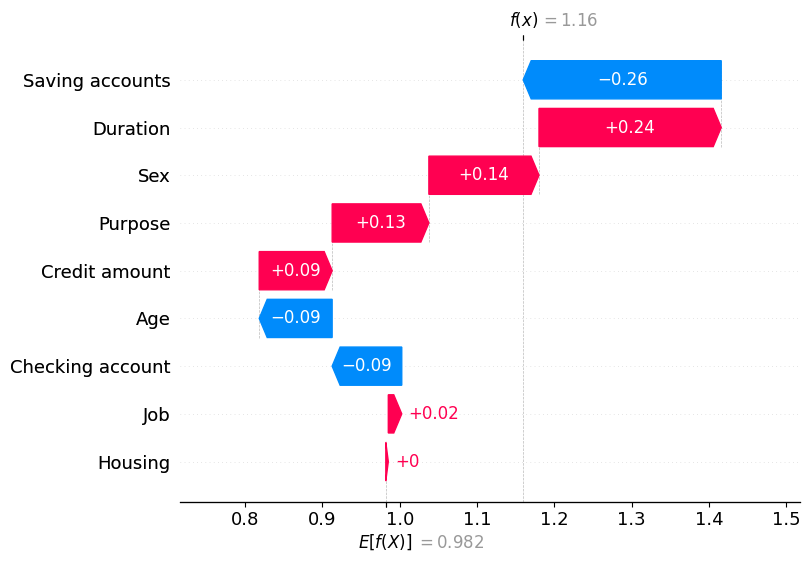

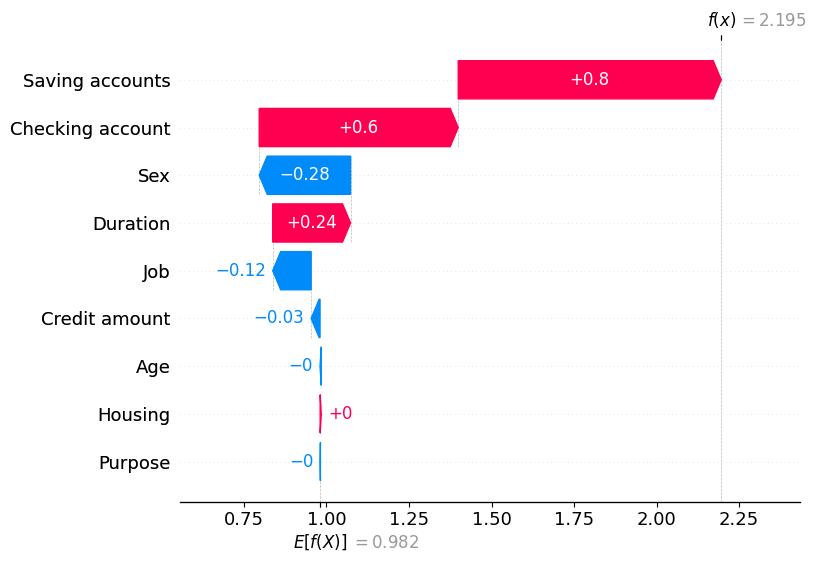

In [39]:
# 9. Explainability with SHAP
import shap
shap.initjs()
explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)


# Global feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


# Local explanations
for sample_idx in [0, 5, 10]:
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value,
        shap_values[sample_idx,:],
        feature_names=X.columns
    )

In [40]:
# 10. Key Insights & Fairness Note
insights = """
# Key Insights from Credit Risk Model


- **Model Performance**: Logistic Regression performed well, and Random Forest provided a useful comparison.
- **Baseline vs Models**: All ML models significantly outperformed the baseline majority-class predictor.
- **Important Features**: Loan **Duration**, **Credit amount**, and engineered **Monthly Installment** were strong predictors of risk.
- **Financial Insights**: Low savings/checking balances correlate with higher default risk.
- **Explainability**: SHAP offered transparency on both global and individual levels.
- **Fairness Note**: The dataset includes **Sex**, which in real-world credit scoring would be excluded for fairness and regulatory reasons.
"""


display(Markdown(insights))


# Key Insights from Credit Risk Model


- **Model Performance**: Logistic Regression performed well, and Random Forest provided a useful comparison.
- **Baseline vs Models**: All ML models significantly outperformed the baseline majority-class predictor.
- **Important Features**: Loan **Duration**, **Credit amount**, and engineered **Monthly Installment** were strong predictors of risk.
- **Financial Insights**: Low savings/checking balances correlate with higher default risk.
- **Explainability**: SHAP offered transparency on both global and individual levels.
- **Fairness Note**: The dataset includes **Sex**, which in real-world credit scoring would be excluded for fairness and regulatory reasons.
